In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
CHANNELS = 3
IMAGE_SIZE = 256
NO_OF_CLASSES = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/PlantVillage',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


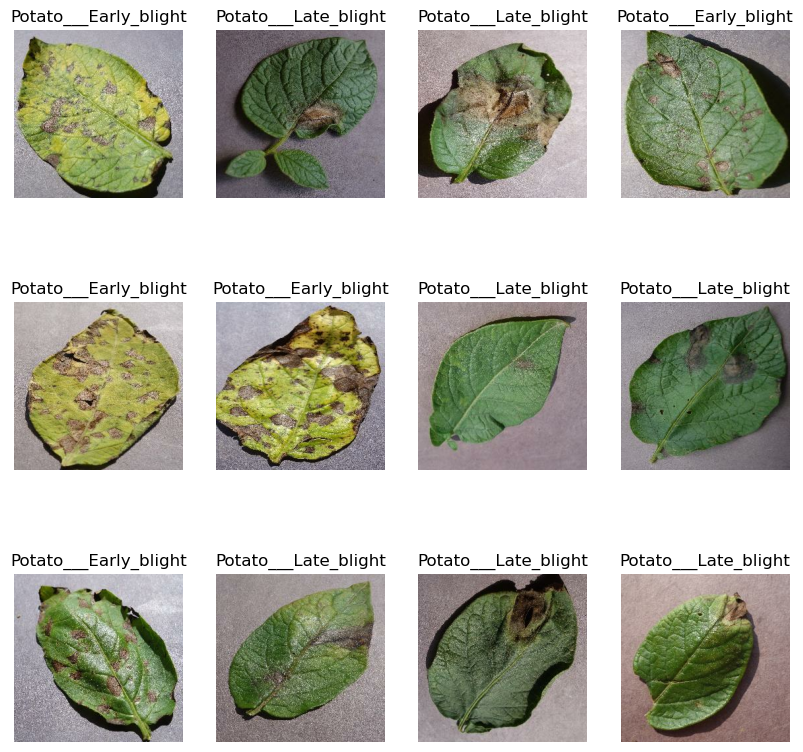

In [11]:
plt.figure(figsize=(10,10))
for batch, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(batch[i].numpy().astype('uint8'))
        plt.title(class_names[label[i].numpy()])
        plt.axis("off")

In [14]:
def split_dataset(dataset, train_split=0.8, test_split=0.1, validation_split=0.1, shuffle=True, shuffle_size=1000):
    assert train_split + test_split + validation_split == 1, "Splits must sum to 1."

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)

    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(dataset_size * train_split)
    test_size = int(dataset_size * test_split)
    validation_size = dataset_size - train_size - test_size

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    validation_dataset = dataset.skip(train_size + test_size).take(validation_size)

    return train_dataset, test_dataset, validation_dataset

In [16]:
train, test, validation = split_dataset(dataset)
print(len(dataset), len(train), len(test), len(validation))

68 54 6 8


In [27]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=NO_OF_CLASSES, activation='softmax')
])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (256, 256, 3)             0         
                                                                 
 sequential_5 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
) 

In [41]:
history = model.fit(
    train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation
)

Epoch 1/10


E:\setups\anaconda\envs\ml\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 431s 7s/step - loss: 0.8863 - accuracy: 0.5194 - val_loss: 0.7247 - val_accuracy: 0.6875
Epoch 2/10
54/54 [==============================] - 401s 7s/step - loss: 0.5517 - accuracy: 0.7565 - val_loss: 0.1901 - val_accuracy: 0.9453
Epoch 3/10
54/54 [==============================] - 364s 7s/step - loss: 0.3496 - accuracy: 0.8644 - val_loss: 0.1856 - val_accuracy: 0.9219
Epoch 4/10
54/54 [==============================] - 346s 6s/step - loss: 0.1699 - accuracy: 0.9413 - val_loss: 0.5355 - val_accuracy: 0.7852
Epoch 5/10
54/54 [==============================] - 359s 7s/step - loss: 0.1943 - accuracy: 0.9302 - val_loss: 0.2741 - val_accuracy: 0.8789
Epoch 6/10
54/54 [==============================] - 372s 7s/step - loss: 0.1565 - accuracy: 0.9466 - val_loss: 0.2590 - val_accuracy: 0.8906
Epoch 7/10
54/54 [==============================] - 408s 8s/step - loss: 0.1242 - accuracy: 0.9507 - val_loss: 0.3476 - val_accuracy: 0.8945
Epoch 8/10
54/54 [======

In [42]:
scores = model.evaluate(test)

6/6 [==============================] - 27s 1s/step - loss: 0.2629 - accuracy: 0.8958


In [43]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [44]:
history.history['accuracy']

[0.5193662047386169,
 0.7564554214477539,
 0.8644366264343262,
 0.9413145780563354,
 0.9301643371582031,
 0.9465962648391724,
 0.9507042169570923,
 0.9653756022453308,
 0.9465962648391724,
 0.9671361446380615]

In [45]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

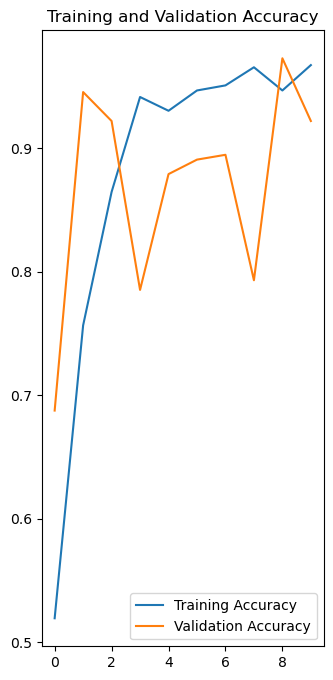

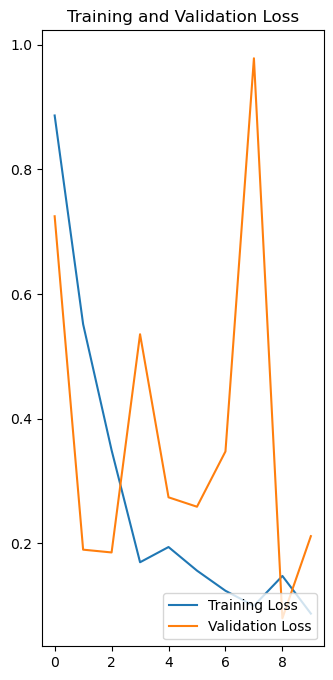

In [48]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.show()

Image to predict
Original label Potato___Late_blight
1/1 [==============================] - 2s 2s/step
Predicted_label Potato___Late_blight


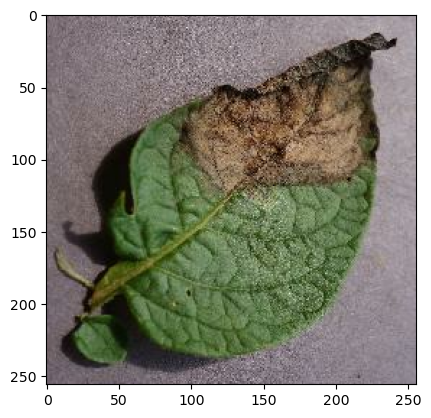

In [50]:
import numpy as np

for images_batch, labels_batch in test.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = class_names[labels_batch[0]]

    print("Image to predict")
    plt.imshow(first_image)
    print(f"Original label {first_label}")
    
    batch_prediction = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print(f"Predicted_label {predicted_label}")
    

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 104ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

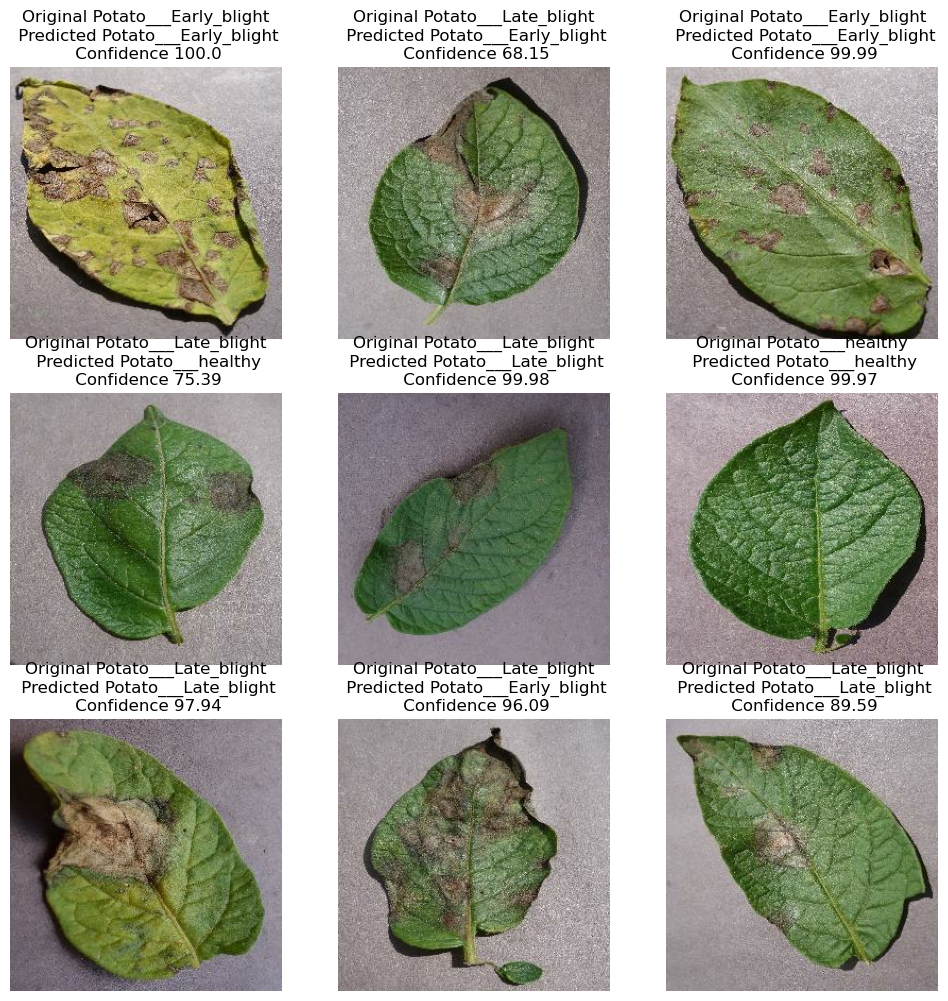

In [53]:
plt.figure(figsize=(12,12))
for images, labels in test.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        original_class = class_names[labels[i]]
        predicted_class, confidence = predict(model, images[i].numpy())

        plt.title(f"Original {original_class}\n Predicted {predicted_class}\n Confidence {confidence}")
        
        plt.axis('off')

In [55]:
import os
model_version = len([int(i) for i in os.listdir('./models')]) + 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets
